<a href="https://colab.research.google.com/github/DaniloTovar/Modelos1/blob/main/Fase1/Modelo_predictivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo predictivo
El modelo predictivo a utilizar se tomará de la competencia [Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer/data?select=train.csv) de Kaggle, especificamente una solución basada en Redes Neuronales Convolucionales tomada de [aquí](https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.api.utils import to_categorical # convert to one-hot-encoding
from keras.api.models import Sequential
from keras.api.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.api.optimizers import RMSprop
from keras.api.callbacks import ReduceLROnPlateau

## 1. Kaggle login
Seleccionar el archivo .json de tu usuario de Kaggle, descargado en la sección API de la configuración de tu cuenta [aqui](https://www.kaggle.com/settings), para poder acceder a los archivos de la competencia.

In [ ]:
files.upload()

In [4]:
!pip install kaggle
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [5]:
!kaggle competitions download -c digit-recognizer
!unzip /content/digit-recognizer.zip
!rm /content/digit-recognizer.zip

 52% 8.00M/15.3M [00:00<00:00, 76.5MB/s]
100% 15.3M/15.3M [00:00<00:00, 107MB/s] 
Archive:  /content/digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## 2. Exploración de datos
Leemos los archivos descargados y extraidos, para realizar una exploración de sus contenidos.

In [6]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [7]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_train['label'].count()

42000

Podemos observar que la tabla *train* posee una columna adicional con el label correspondiente a la imagen, con el que podremos evaluar la certeza de las predicciones.

A continuación, mostraremos la primera imagen de la tabla *train* y crearemos una version de la misma sin la columna *label*

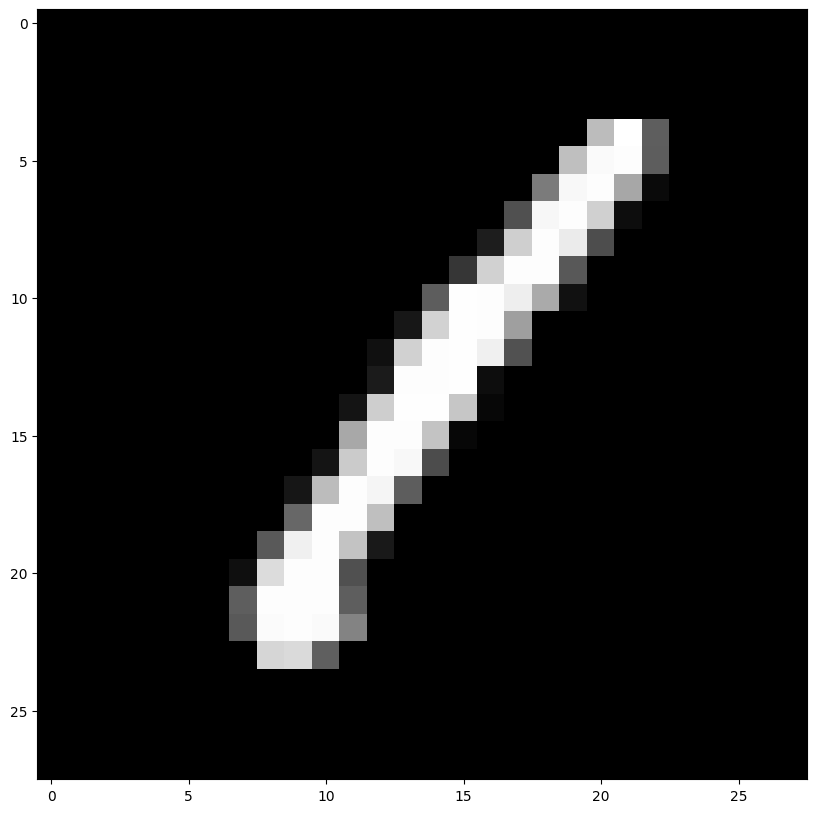

In [10]:
first_image = df_train.iloc[0, 1:].values
width, height = 28, 28

first_image = first_image.reshape((height, width))


plt.figure(figsize=(10,10))
plt.imshow(first_image, cmap='gray')
plt.show()

In [11]:
df_train_drop = df_train.drop(columns='label')
df_train_drop.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
train_labels = df_train['label']
train_labels.head()

,label
0,1
1,0
2,1
3,4
4,0


## 2.1 Comprobación por datos faltantes

In [13]:
df_train_drop.isnull().any().describe()

,0
count,784
unique,1
top,False
freq,784


In [14]:
df_test.isnull().any().describe()

,0
count,784
unique,1
top,False
freq,784


No hay datos faltantes

## 2.2 Normalización y Reshape
Acorde al modelo referenciado, se realizan estos cambios para optimizar y acomodar los datos a Keras.

> We perform a grayscale normalization to reduce the effect of illumination's differences. Moreover the CNN converg faster on [0..1] data than on [0..255].


> Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices. Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.


In [15]:
# Normalización de los datos
df_train_drop = df_train_drop / 255.0
df_test = df_test / 255.0

In [16]:
# Reshape de las imagenes a 3 dimesiones (height = 28px, width = 28px , canal = 1)
df_train_drop = df_train_drop.values.reshape(-1,28,28,1)
df_test = df_test.values.reshape(-1,28,28,1)

## 2.3 Label encoding

In [17]:
train_labels = to_categorical(train_labels, num_classes = 10)
train_labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## 2.4 Split training and valdiation set
Siguiendo el modelo, se realizara un entrenamiendo dividido, donde el 10% de los datos serán utilizados para validación mientras que el 90% restante se utilizará para entrenar el modelo.

Debido a que se tienen 42000 se espera que no existan problemas de cesgo al realizar esta division aletoria.

In [18]:
# Set the random seed
random_seed = np.random.seed(2)

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(df_train_drop, train_labels, test_size = 0.1, random_state=random_seed)

## 3. CNN (Red Neuronal Convolucional)

## 3.1 Definicion del modelo

In [19]:
from keras import Sequential
from keras.api.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

## 3.2 Optimizer and annealer

In [20]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

In [21]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [22]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [23]:
epochs = 5
batch_size = 86

## 3.3 Data augmentation
Realizamos cambios a algunas imagenes para evitar overfitting y mejorar las predicciones ante alteraciones que ocurren en la realidad como tamaño, rotacion y decentralización.

In [24]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [25]:
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch = ((X_train.shape[0]//batch_size)),
                              validation_steps = ((X_train.shape[0]//batch_size))
                              , callbacks=[learning_rate_reduction])

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


439/439 - 309s - 703ms/step - accuracy: 0.8670 - loss: 0.4218 - val_accuracy: 0.9784 - val_loss: 0.0638 - learning_rate: 0.0010
Epoch 2/5
439/439 - 11s - 25ms/step - accuracy: 0.9535 - loss: 0.1658 - val_accuracy: 0.9729 - val_loss: 0.0806 - learning_rate: 0.0010
Epoch 3/5
439/439 - 279s - 636ms/step - accuracy: 0.9614 - loss: 0.1300 - val_accuracy: 0.9829 - val_loss: 0.0520 - learning_rate: 0.0010
Epoch 4/5
439/439 - 11s - 25ms/step - accuracy: 0.9419 - loss: 0.1431 - val_accuracy: 0.9838 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 5/5
439/439 - 312s - 710ms/step - accuracy: 0.9721 - loss: 0.0937 - val_accuracy: 0.9843 - val_loss: 0.0418 - learning_rate: 0.0010


# 4. Evaluación del modelo

## 4.1 Curvas de entrenamiento y validacion

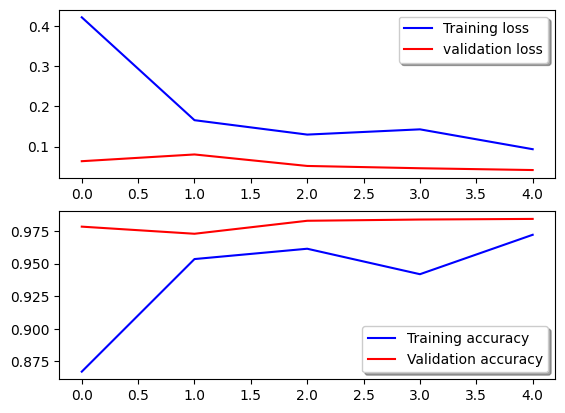

In [26]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Matriz de confusion

132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step


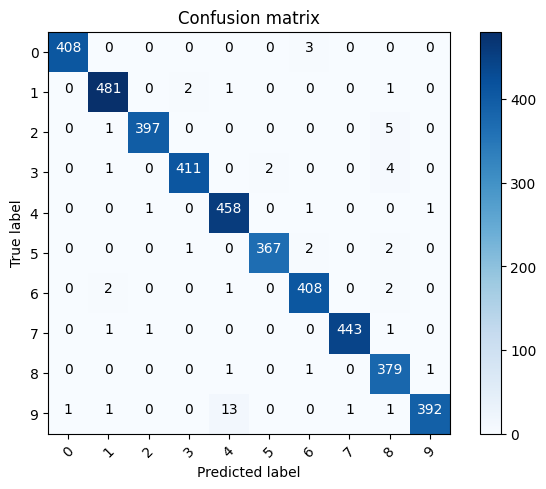

In [27]:
# Look at confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8


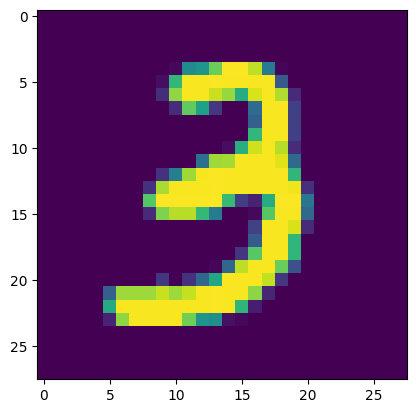

In [39]:
n = 7
pred = history.model.predict(df_test[0:8])
pred = np.argmax(Y_pred,axis = 1)
print(pred[n])

g = plt.imshow(df_test[n][:,:,0])

# 5. Guardar el modelo

In [30]:
model.save("NumberPrediction.keras", include_optimizer=True)

with open("model.pkl", "wb") as f:
    pickle.dump(model, f)